# Portfolio Optimization (포트폴리오 최적화)

- 위험회피적 투자자가 시장 위험의 주어진 수준에 따라 기대수익을 최적화하거나 최대화하여 보상 수준을 선택  


- 방법 1 – Monte Carlo Simulation 에 의한 최적 포트폴리오 탐색
- 방법 2 – scipy 를 이용한 수학적 최적화 (Mathematical Optimization)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import FinanceDataReader as fdr
import korean

In [2]:
start = datetime.datetime(2015,1,1)

- portfolio 생성

In [3]:
stock_list = [('000990', 'DB하이텍'), ('005930', '삼성전자'), ('016360', '삼성증권'), ('035720', '카카오')]
#stock_list = [('005930', '삼성전자'), ('081660', '휠라홀딩스'), ('138930', 'BNK금융'), ('139480', '이마트'),  ('035720', '카카오')]
code_names = [code[1] for code in stock_list]

portfolio = pd.DataFrame([])
for stock in stock_list:
    df = fdr.DataReader(stock[0], start)
    if len(df) == 0:
        print(stock)
    portfolio = pd.concat([portfolio, df['Close']], axis=1)
    
portfolio.columns = code_names
portfolio.head()

DB하이텍   삼성전자   삼성증권    카카오
2015-01-02 00:00:00   4645  26600  43261  27538
2015-01-05 00:00:00   4580  26660  42436  29003
2015-01-06 00:00:00   4455  25900  42485  29164
2015-01-07 00:00:00   4450  26140  42485  29746
2015-01-08 00:00:00   4475  26280  43261  29565

In [4]:
portfolio.head()

DB하이텍   삼성전자   삼성증권    카카오
2015-01-02 00:00:00   4645  26600  43261  27538
2015-01-05 00:00:00   4580  26660  42436  29003
2015-01-06 00:00:00   4455  25900  42485  29164
2015-01-07 00:00:00   4450  26140  42485  29746
2015-01-08 00:00:00   4475  26280  43261  29565

- 포트폴리오 수익률 생성 (daily log return)

In [5]:
log_ret = np.log(portfolio / portfolio.shift())
log_ret.head()

DB하이텍      삼성전자      삼성증권       카카오
2015-01-02 00:00:00       NaN       NaN       NaN       NaN
2015-01-05 00:00:00 -0.014092  0.002253 -0.019254  0.051832
2015-01-06 00:00:00 -0.027672 -0.028921  0.001154  0.005536
2015-01-07 00:00:00 -0.001123  0.009224  0.000000  0.019760
2015-01-08 00:00:00  0.005602  0.005341  0.018100 -0.006103

asset 간의 상관 계수

In [6]:
portfolio.pct_change().corr()

DB하이텍      삼성전자      삼성증권       카카오
DB하이텍  1.000000  0.302194  0.276229  0.272952
삼성전자   0.302194  1.000000  0.393826  0.224085
삼성증권   0.276229  0.393826  1.000000  0.270402
카카오    0.272952  0.224085  0.270402  1.000000

## Method 1 - Monte Carlo Simulation

- 가능한 allocation 의 조합을 loop 로 반복하여 최적의 조합 (Highest Sharpe ratio) 을 찾는다.


- Sharpe ratio = (기대수익률 - 무위험수익률) / (기대수익률과 무위험수익률 공분산의 표준편차)  

$$SR=\frac{R_p - R_f}{\sigma_p}$$ 



위의 자산을 1/4 씩 동일 비중으로 포트폴리오 구성한 경우 portfolio 의 변동성 계산

In [7]:
weights = np.array([0.25, 0.25, 0.25, 0.25])

포트폴리오의 연간 covariance

In [8]:
cov = np.dot(log_ret.cov() * 252, weights)
cov

array([0.09069212, 0.03938079, 0.0492327 , 0.05804929])

포트폴리오의 연간 수익

In [9]:
ret = np.sum(log_ret.mean() * weights) * 252
ret

0.13000918658389676

포트폴리오의 연간 변동성

In [10]:
vol = np.sqrt(np.dot(weights.T, cov))
vol

0.24359541495243967

포트폴리오의 샤프지수

In [11]:
ret / vol

0.5337094978133319

### Putting all together
- 샤프비율 계산 함수 
    - 연간 기대 수익률, 연간 covariance, sharp ratio 반환 

In [12]:
def get_ret_vol_sr(weights, log_ret):
    weights = np.array(weights)
    cov = np.dot(log_ret.cov() * 252, weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, cov))
    sr = ret / vol
    return np.array([ret, vol, sr])

In [13]:
get_ret_vol_sr(weights, log_ret)

array([0.13000919, 0.24359541, 0.5337095 ])

- 각 자산의 비중을 무작위로 선택하여 특정 자산 비중에서의 연간 수익률, 변동성, 샤프비율 계산

In [14]:
np.random.seed(101)
cols = len(log_ret.columns)
iteration = 50_000

all_weights = np.zeros((iteration, cols))
ret_arr = np.zeros(iteration)
vol_arr = np.zeros(iteration)
sharpe_arr = np.zeros(iteration)

for i in range(iteration):
    weights = np.random.random(cols) 
    weights = weights / np.sum(weights) #각 자산의 비중
    all_weights[i, :] = weights  # iteration 별 자산 비중 저장
    
    rvs = get_ret_vol_sr(weights, log_ret) #특정 자산비중에서의 ret,vol,sr
    ret_arr[i] = rvs[0]
    vol_arr[i] = rvs[1]
    sharpe_arr[i] = rvs[2]

In [15]:
sharpe_arr.shape

(50000,)

- 최적 샤프 비율 (highest sharpe ratio)을 구하고, 그 때의 최적 자산 배분 비율을 구함

In [16]:
# MC method 에 의해 simulation 한 최적 sharpe ratio
print('최적 Sharpe Ratio = {}'.format(sharpe_arr.max()))

max_idx = sharpe_arr.argmax()
max_idx

최적 Sharpe Ratio = 0.6974968041567453


45161

최적 Sharpe ratio 일 때의 daily return 과 volatility, 최적 portfolio 비율

In [17]:
print('return = {}'.format(ret_arr[max_idx]))
print('volatility = {}'.format(vol_arr[max_idx]))

with np.printoptions(precision=5, suppress=True):
    print('최적 자산 배분 비율 = {} : {}'.format(log_ret.columns.values, all_weights[max_idx]))

return = 0.19794140274157127
volatility = 0.28378825761198584
최적 자산 배분 비율 = ['DB하이텍' '삼성전자' '삼성증권' '카카오'] : [0.42414 0.37479 0.00023 0.20084]


- 포트폴리오 조합 및 최적 포트폴리오 시각화

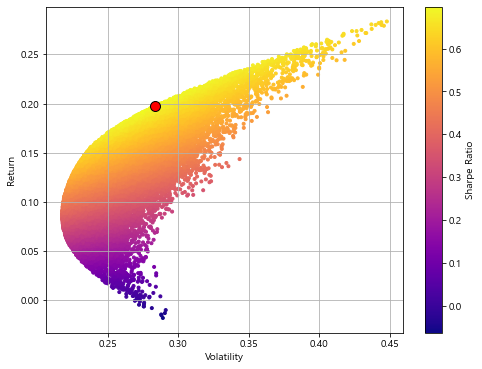

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, marker='.', cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.xlabel('Volatility')
plt.ylabel('Return')
#최적 portfolio
plt.plot(vol_arr[max_idx], ret_arr[max_idx], 'ro', markeredgecolor='k', markersize=10);

## Method 2 - Scipy 를 이용한 수학적 최적화 (Mathematical Optimization)

최적화 알고리즘을 이용한 최적 포트폴리오 계산  

In [19]:
from scipy.optimize import minimize

Sharpe ratio 의 maximize 를 minimize 함수로 하므로 sharpe ratio * (-1) 을 minimize 하는 trick 을 이용한다.

In [20]:
# 목적 함수 - 샤프비율 최대화
def neg_sharpe(weights):
    return get_ret_vol_sr(weights, log_ret)[2] * -1

#constraint 함수 정의
def check_sum(weights):
    # return 0 if sum of weights is 1.0
    return np.sum(weights) - 1

cons = ({'type': 'eq', 'fun': check_sum})

# 각 weight 에 대한 (min, max)
bounds = tuple((0, 1) for _ in log_ret.columns)

# 각 asset의 초기 비중을 동일하게 가져간다고 가정
x0 = [1/len(log_ret.columns) for _ in log_ret.columns]

opt_results = minimize(neg_sharpe, x0, method='SLSQP', bounds=bounds, constraints=cons)
opt_results

     fun: -0.6976340034097587
     jac: array([-1.64486468e-04,  1.55046582e-05,  4.23993737e-01,  3.03864479e-04])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.41598049, 0.37811669, 0.        , 0.20590282])

- objective function을 minimize (Sharpe Ratio를 최대화)하는 x 값 (asset weights)

- MC method로 구한 결과와 수학적 optimize 결과가 유사하면 successful result 이다.

In [21]:
with np.printoptions(precision=5, suppress=True):
    print('scipy를 이용한 최적 자산 비중 = {} : {}'.format(log_ret.columns.values, opt_results.x))  
    print('MC를 이용한 최적 자산 비중    = {} : {}'.format(log_ret.columns.values, all_weights[max_idx]))

scipy를 이용한 최적 자산 비중 = ['DB하이텍' '삼성전자' '삼성증권' '카카오'] : [0.41598 0.37812 0.      0.2059 ]
MC를 이용한 최적 자산 비중    = ['DB하이텍' '삼성전자' '삼성증권' '카카오'] : [0.42414 0.37479 0.00023 0.20084]


- optimum asset weights 일 때의 return, volatility, sharpe ratio 구하기

In [30]:
opt_rvs = get_ret_vol_sr(opt_results.x, log_ret)

#with np.printoptions(precision=3, suppress=True):
print('최적 자산 비중 {}: {} 일 때'.format(log_ret.columns.values, opt_results.x))
print('최적 Sharpe Ratio = {:.3f}'.format(opt_rvs[2]))
print('최적 SR일 때의 수익률 = {:.3f}'.format(opt_rvs[0]))
print('최적 SR일 때의 변동성 = {:.3f}'.format(opt_rvs[1]))

최적 자산 비중 ['DB하이텍' '삼성전자' '삼성증권' '카카오']: [0.41598049 0.37811669 0.         0.20590282] 일 때
최적 Sharpe Ratio = 0.698
최적 SR일 때의 수익률 = 0.197
최적 SR일 때의 변동성 = 0.282


## Efficient Frontier (효율적 투자선)

- Efficient Frontier 는 정의된 수준의 위험 또는 주어진 기대수익 수준의 가장 낮은 위험에 대해 가장 높은 수익률을 제공하는 최적 포트폴리오 세트이다. 

- 효율적 전선 아래에 있는 포트폴리오는 동일한 위험 수준에 대해 효율적 전선 상의 포트폴리오 보다 낮은 수익을 제공하므로 최선의 포트폴리오가 아님. 효율적 전선 오른쪽의 포트폴리오는 동일한 수익에 대해 위험 수준이 높으므로 최선의 포트폴리오가 아님.

In [23]:
# return 의 시각화 범위 설정
frontier_y = np.linspace(0.01, 0.30, 100)

In [24]:
# 목적 함수 설정 - 특정 asset weights에서 가장 낮은 변동성
def minimize_volatility(weights):
    return get_ret_vol_sr(weights, log_ret)[1]

In [25]:
# 최적화 함수
def optimized_result(possible_return):
    cons = ({'type': 'eq',  'fun': check_sum},
                 {'type': 'eq', 
                    'fun': lambda w: get_ret_vol_sr(w, log_ret)[0] - possible_return})
    
    result = minimize(minimize_volatility, x0, 
                      method='SLSQP', bounds=bounds, constraints=cons)   
    return result

- possible return이 frontier_y일 때의 volatility를 구한다.  
- optimized_result 의 fun 이 목적함수의 반환값 $\rightarrow$ 즉, volatility 값  
    - fun : Values of objective function  
    - x : 자산 비중

In [26]:
result = optimized_result(frontier_y[0])
result

     fun: 0.2557127214227344
     jac: array([0.16023163, 0.15339783, 0.29748114, 0.12914901])
 message: 'Optimization terminated successfully'
    nfev: 20
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([3.90312782e-18, 2.35476381e-01, 7.17947824e-01, 4.65757952e-02])

- 모든 return (frontier_y)에 대한 volatility 를 구함

In [27]:
frontier_volatility = []

for possible_return in frontier_y:
    result = optimized_result(possible_return)
    frontier_volatility.append(result.fun)
    
frontier_volatility[:5]

[0.2557127214227344,
 0.25283916215288116,
 0.2500579100034724,
 0.247372078500432,
 0.24478480870189115]

- 모든 possible return 과 volatility를 연결하는 plot 시각화.

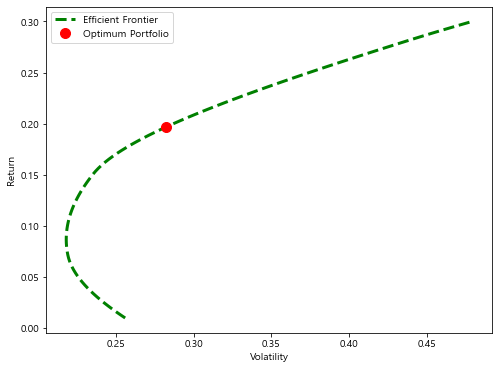

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(frontier_volatility, frontier_y, 'g--', linewidth=3, label='Efficient Frontier')

plt.plot(opt_rvs[1], opt_rvs[0], 'ro', markersize=10, label='Optimum Portfolio');

plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend()